- 3) Bio.PopGene 으로 dataset 탐색하기

We will analyze the 10 percent sampling of chromosome 2 without the offspring.
- **(hapmap10_auto_noofs_2.gp)**
- **(hapmap10_auto_noofs_2.pops)**



i) [GenePop](http://kimura.univ-montp2.fr/~rousset/Genepop.htm) 설치

In [3]:
from Bio.PopGen.GenePop import Controller as gpc

from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

i) GenePop application과 interact하는 object 생성

In [2]:
ctrl = gpc.GenePopController()

ii) population name

In [4]:
! cat hapmap10_auto_noofs_2.pops

ASW
CEU
CHB
CHD
GIH
JPT
LWK
MEX
MKK
TSI
YRI


In [5]:
my_pops = [l.rstrip() for l in open('hapmap10_auto_noofs_2.pops')] 
num_pops = len(my_pops)
print my_pops
print num_pops

['ASW', 'CEU', 'CHB', 'CHD', 'GIH', 'JPT', 'LWK', 'MEX', 'MKK', 'TSI', 'YRI']
11


iii) genotypic information 계산하여 2 iterator값을 얻는다 (GenePop이 설치되어 있어야 함-오래걸림)

In [6]:
pop_iter, loci_iter = ctrl.calc_allele_genotype_freqs('hapmap10_auto_noofs_2.gp')

iv) 아래 값들을 counting
- 1) num_reads : number of read를 counting
- 2) fix_pops : maf==0인 갯수
- 3) MAFs : maf를 구간에 따라 counting하여 MAFs에 넣음.

In [7]:
fix_pops = [0 for i in range(num_pops)]
num_reads = [defaultdict(int) for i in range(num_pops)]

num_buckets = 20                # MAF를 20등분해서 counting함
MAFs = []
for i in range(num_pops):
    MAFs.append([0] * num_buckets)
    
for locus_data in loci_iter:    # 각 locus에 대해서
    locus_name = locus_data[0]  #  2/rs13386087/24503
    allele_list = locus_data[1] # [3,4]
    pop_of_loci = locus_data[2] # [('2446/NA201', [0.083, 0.917], 96), ('1375/NA122', [0.009, 0.991], 218), ...
    for i in range(num_pops):   # 각 11개 인종에 따라
        locus_num_reads = pop_of_loci[i][2] 
        num_reads[i][locus_num_reads] += 1  # 1) number of read를 counting
        maf = min(pop_of_loci[i][1])  
        if maf == 0:
            fix_pops[i] += 1                # 2) maf ==0일 때마다 fix_pops 에 +1
        else:
            bucket = min([num_buckets - 1, int(maf * 2 * num_buckets)])
            MAFs[i][bucket] += 1            # 3) maf를 구간에 따라 counting하여 MAFs에 넣음.

3가지 plot
- 1) 각 인종에 따른 fixed allele 갯수를 barplot
- 2) number of reads 값중에 최대값을 barplot으로 그림. 이는 각 인종당 haplotype 수로 볼 수 있음
- 3) 0, 7, 8 번째, 즉 ASW, MEX, MKK 세 인종에 대해 MAFs plot을 그림.(sampling effect를 확인할 수 있음)

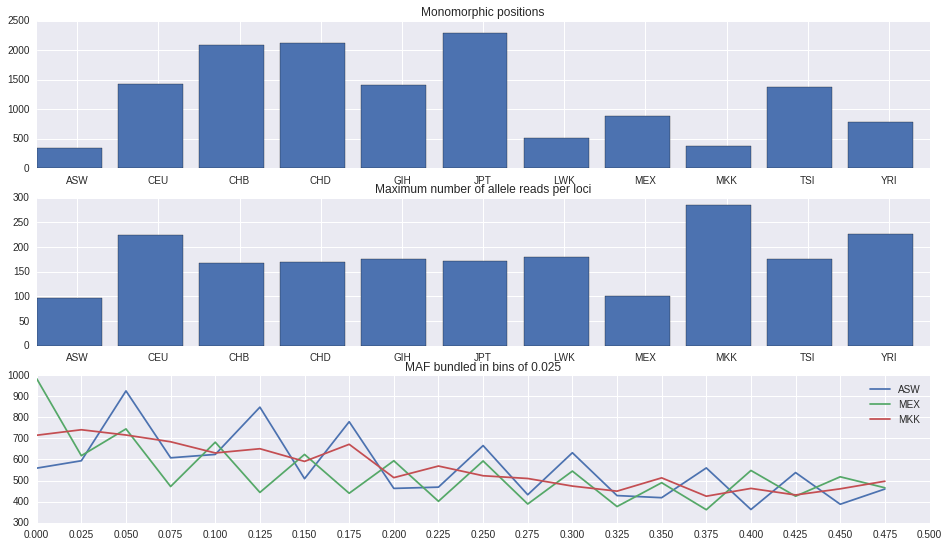

In [8]:
fig, axs = plt.subplots(3, figsize=(16, 9), squeeze=False)
axs[0, 0].bar(range(num_pops), fix_pops)
axs[0, 0].set_xlim(0, 11)
axs[0, 0].set_xticks(0.5 + np.arange(num_pops))
axs[0, 0].set_xticklabels(my_pops)
axs[0, 0].set_title('Monomorphic positions')

axs[1, 0].bar(range(num_pops), [np.max(vals.keys()) for vals in num_reads])
axs[1, 0].set_xlim(0, 11)
axs[1, 0].set_xticks(0.5 + np.arange(num_pops))
axs[1, 0].set_xticklabels(my_pops)
axs[1, 0].set_title('Maximum number of allele reads per loci')

for pop in [0, 7, 8]:
    axs[2, 0].plot(MAFs[pop], label=my_pops[pop])
axs[2, 0].legend()
axs[2, 0].set_xticks(range(num_buckets + 1))
axs[2, 0].set_xticklabels(['%.3f' % (x / (num_buckets * 2.)) for x in range(num_buckets + 1)])
axs[2, 0].set_title('MAF bundled in bins of 0.025')
None

v) 각 population에 대해서 expected heterozygosity를 계산하여 exp_hes에 넣음

- High heterozygosity means lots of genetic variability
- Low heterozygosity means little genetic variability.
- heterozygosity = 2p(1-p)

In [8]:
exp_hes = []
for pop_data in pop_iter:        # 각 population에 대해서
    pop_name, allele = pop_data
    print(pop_name)
    exp_vals = []
    for locus_name, vals in allele.items():
        geno_list, heterozygosity, allele_cnts, summary = vals
        cexp_ho, cobs_ho, cexp_he, cobs_he = heterozygosity
        exp_vals.append(cexp_he / (cexp_he + cexp_ho))
    exp_hes.append(exp_vals)

2446/NA20127  
1375/NA12264  
NA18594/NA18594  
NA18140/NA18140  
NA20881/NA20881  
NA19007/NA19007  
NA19372/NA19372  
M005/NA19652  
2581/NA21371  
NA20757/NA20757  
Y105/NA19099  


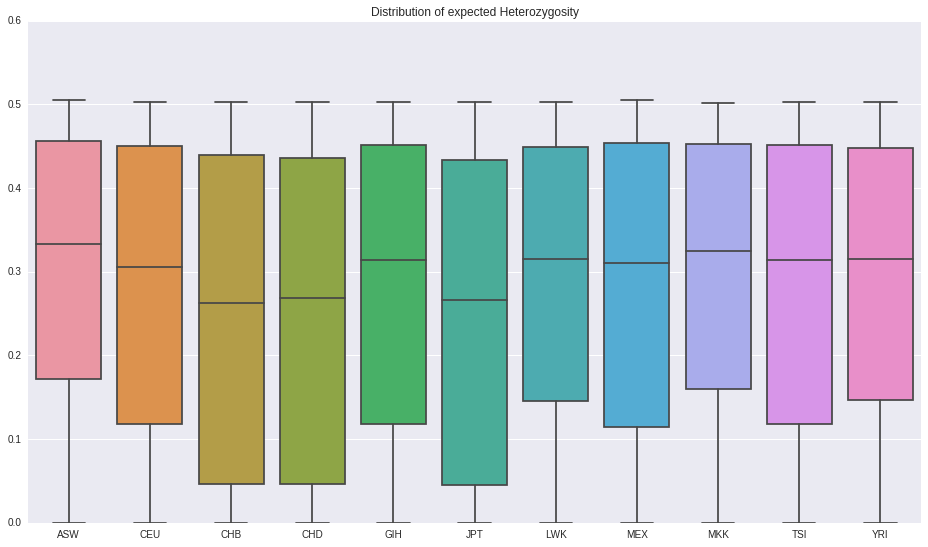

In [8]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(data=exp_hes, ax=ax)
ax.set_title('Distribution of expected Heterozygosity')
ax.set_xticks(np.arange(num_pops))
ax.set_xticklabels(my_pops)